In [17]:
import numpy as np
from scipy.optimize import minimize

def trust_region_method(func, grad, hess, x0, max_radius=1.0, eta=0.1, max_iter=100, tol=1e-6):
    """
    基础的信赖域方法实现
    
    参数:
    func: 目标函数
    grad: 目标函数的梯度
    hess: 目标函数的Hessian矩阵
    x0: 初始点
    max_radius: 最大信赖域半径
    eta: 用于决定是否接受步长的阈值
    max_iter: 最大迭代次数
    tol: 收敛容差
    
    返回:
    x: 最优点
    f: 最优值
    """
    x = x0
    radius = max_radius / 2
    f = func(x)
    
    for i in range(max_iter):
        g = grad(x)
        H = hess(x)
        
        # 求解信赖域子问题
        def subproblem(p):
            return f + np.dot(g, p) + 0.5 * np.dot(p, np.dot(H, p))
        
        # 使用BFGS方法求解子问题，添加信赖域约束
        res = minimize(subproblem, np.zeros_like(x), method='BFGS',
                       constraints={'type': 'ineq', 'fun': lambda p: radius - np.linalg.norm(p)})
        p = res.x
        
        # 计算实际减少量和预测减少量
        actual_reduction = f - func(x + p)
        predicted_reduction = -(np.dot(g, p) + 0.5 * np.dot(p, np.dot(H, p)))
        
        # 计算比率
        rho = actual_reduction / predicted_reduction if predicted_reduction != 0 else 0
        
        # 更新信赖域半径
        if rho < 0.25:
            radius = 0.25 * radius
        elif rho > 0.75 and np.linalg.norm(p) == radius:
            radius = min(2 * radius, max_radius)
        
        # 更新当前点
        if rho > eta:
            x = x + p
            f = func(x)
        
        # 检查收敛性
        if np.linalg.norm(g) < tol:
            break
    
    return x, f

# 示例：优化Rosenbrock函数
def rosenbrock(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def rosenbrock_grad(x):
    return np.array([-2*(1-x[0]) - 400*x[0]*(x[1]-x[0]**2),
                     200*(x[1]-x[0]**2)])

def rosenbrock_hess(x):
    return np.array([[2 - 400*x[1] + 1200*x[0]**2, -400*x[0]],
                     [-400*x[0], 200]])

# 运行优化
x0 = np.array([-1.2, 1.0])
result, value = trust_region_method(rosenbrock, rosenbrock_grad, rosenbrock_hess, x0)

print("最优点:", result)
print("最优值:", value)

最优点: [-1.17528092  1.3806742 ]
最优值: 4.731884401423877


修改代码。我们假设：
1. 可以获得目标函数的梯度
2. 不能获得完整的hessian矩阵，只能获得其对角线。
3. 对子问题添加正则化项，是的其有closed form solution，从而不使用其他solvers。

优化结果: [0.89646151 0.80461085]
最终目标函数值: 0.01081384584114998
迭代次数: 1000


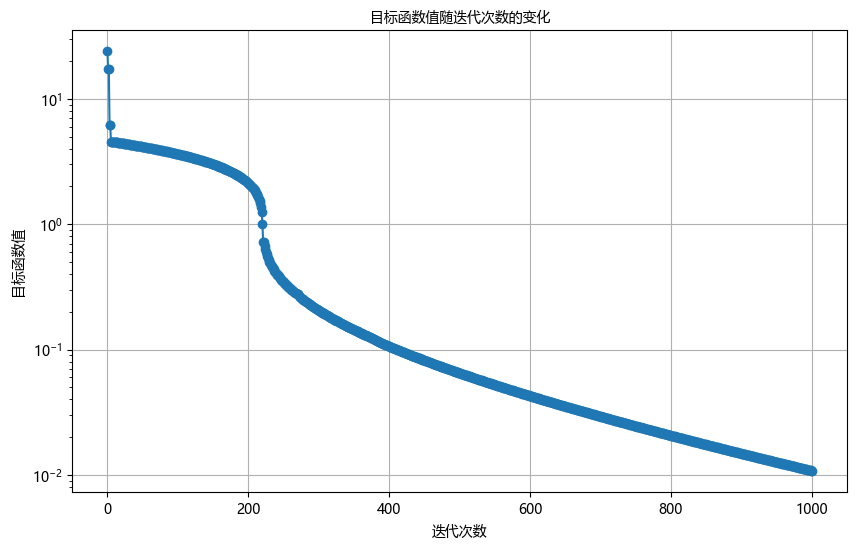

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 设置中文字体，这里使用微软雅黑作为示例
# 如果您的系统中没有这个字体，请替换为您系统中可用的中文字体
font_path = r'C:\Windows\Fonts\msyh.ttc'  # 微软雅黑字体路径
font_prop = fm.FontProperties(fname=font_path)

def objective_function(x):
    # Rosenbrock 函数
    return np.sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)

def gradient(x):
    # Rosenbrock 函数的梯度
    grad = np.zeros_like(x)
    grad[0] = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    grad[-1] = 200 * (x[-1] - x[-2]**2)
    grad[1:-1] = 200 * (x[1:-1] - x[:-2]**2) - 400 * x[1:-1] * (x[2:] - x[1:-1]**2) - 2 * (1 - x[1:-1])
    return grad

def diagonal_hessian(x):
    # Rosenbrock 函数的对角线 Hessian 矩阵（近似）
    n = len(x)
    diag = np.zeros(n)
    diag[0] = 1200 * x[0]**2 - 400 * x[1] + 2
    diag[-1] = 200
    diag[1:-1] = 202 + 1200 * x[1:-1]**2 - 400 * x[2:]
    return diag

def solve_subproblem(g, B, delta):
    # 解决信赖域子问题
    p = -g / (B + 1e-8)  # 添加小量以避免除零错误
    if np.linalg.norm(p) > delta:
        p = p * delta / np.linalg.norm(p)
    return p

def trust_region_method(x0, max_iter=1000, initial_delta=1.0, eta=0.1, tol=1e-6):
    x = x0
    delta = initial_delta
    
    # 用于跟踪每次迭代的函数值
    f_values = [objective_function(x0)]
    
    for i in range(max_iter):
        f = objective_function(x)
        g = gradient(x)
        B = diagonal_hessian(x)
        
        # 确保B是正定的
        B = np.maximum(B, 1e-6)
        
        p = solve_subproblem(g, B, delta)
        
        # 计算实际减少量和预测减少量
        actual_reduction = f - objective_function(x + p)
        predicted_reduction = -np.dot(g, p) - 0.5 * np.dot(p, B * p)
        
        rho = actual_reduction / (predicted_reduction + 1e-8)
        
        if rho > eta:
            x = x + p
            if rho > 0.75 and np.linalg.norm(p) == delta:
                delta = min(2 * delta, 10)
        else:
            delta = 0.25 * delta
        
        # 记录当前迭代的函数值
        f_values.append(objective_function(x))
        
        # 检查收敛性
        if np.linalg.norm(g) < tol:
            break
    
    return x, objective_function(x), i+1, f_values

def plot_function_values(f_values):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(f_values)), f_values, marker='o')
    plt.title('目标函数值随迭代次数的变化', fontproperties=font_prop)
    plt.xlabel('迭代次数', fontproperties=font_prop)
    plt.ylabel('目标函数值', fontproperties=font_prop)
    plt.yscale('log')  # 使用对数刻度以更好地显示值的变化
    plt.grid(True)
    
    # 设置刻度标签的字体
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    
    plt.show()

# 使用示例
x0 = np.array([-1.2, 1.0])  # Rosenbrock 函数的标准起始点
# x0 = np.array([20, 1.0])

result, final_value, iterations, f_values = trust_region_method(x0)

print(f"优化结果: {result}")
print(f"最终目标函数值: {final_value}")
print(f"迭代次数: {iterations}")

# 绘制函数值随迭代次数的变化图
plot_function_values(f_values)